<CENTER>
</br>
<p><font size="5">  SAGAR Hedi   </font></p>
<p><font size="5"> Study of Neural Networks part. I  </font></p>
</p>
</CENTER>

# Classification problem

We first define a binary classification problem in 2D with nonlinearly separable classes. 

In [1]:
# imports and definition of the two functions to generate the data

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.datasets import make_moons

from matplotlib.colors import ListedColormap

def twospirals(n_points, noise=.5):
    n = np.sqrt(np.random.rand(n_points,1)) * 720 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
        np.hstack((np.zeros(n_points),np.ones(n_points))))

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

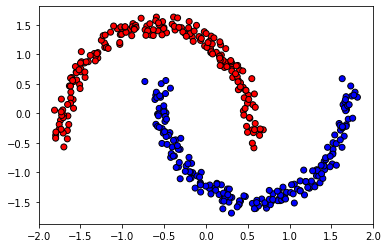

In [2]:
# data generation, normalization and plotting

noise = 0.5    
n_samples = 500

# (X,Y) = twospirals(n_points=n_samples, noise=noise)
X,Y = make_moons(n_samples=n_samples, shuffle=True, noise=noise/10, random_state=None)

X = StandardScaler().fit_transform(X) #zero mean and unit variance

Y = Y.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

fig = plt.figure()
plt.scatter(x_train[:,0],x_train[:,1],c=y_train[:,0],cmap=cm_bright,edgecolors='k')
plt.show()


In [3]:
# Initialize variables depending on the problem to tackle

input_size = 2
output_size = 1

nb_neurons_hidden_layer = 20

Loss function used : the binary cross entropy function. It takes as argument the true labels and the output of the model. 

\begin{equation*}
L(\mathbf{y},\mathbf{t}) = \sum_{n=1}^{N} l(y_{n},t_{n}) = -\sum_{n=1}^{N}  \left( t_{n} \textrm{ln}(y_{n}) + (1-t_{n}) \textrm{ln}(1-y_{n}) \right)
\end{equation*}

where $\mathbf{y}$ is the output of the model (concatenated for each sample) and $\mathbf{t}$ is the set of all true target variables, for each sample.

In [4]:
# initialize all variables for forward pass

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_vectorized(x):
    return np.array(list(map(sigmoid, x)))

def CrossEntropy(yHat, y):
    if y == 1:
        return -np.log(yHat)
    else:
        return -np.log(1 - yHat)


In [5]:
def forward(x,W1,b1,W2,b2):
    z1 = np.dot(W1,x) + b1
    a1 = sigmoid_vectorized(z1)
    z2 = np.dot(W2,a1) + b2
    a2 = sigmoid_vectorized(z2)
    return(z1,a1,z2,a2)


In [6]:
ds = 1 # seed for backward differentiation (initial value of ds/dl, in practice set to 1 if s=l at the output)

# if a is a variable, we denote by da the value of ds/da for the current value of the parameters,
    
def backward(W1,b1,W2,b2,y,ds,z1,a1,z2,a2,x):
    da2 = ds*(a2-y)/(a2*(1-a2)) 
    dz2 = a2*(1-a2)*da2
    dw2 = dz2 * a1
    db2 = dz2
    da1 = np.dot(dz2,W2)
    dz1 = da1*(a1*(1-a1))
    dw1 = np.zeros((nb_neurons_hidden_layer,input_size))
    for i in range(nb_neurons_hidden_layer):
        dw1[i,:] = dz1[i]*x
    db1 = dz1
    return dw2,db2,dw1,db1

In [7]:
def network_training(X,Y,lr,epochs,ds):
    
    # random initialization of the parameters

    W1 = np.random.randn(nb_neurons_hidden_layer,input_size)
    b1 = np.random.randn(nb_neurons_hidden_layer)

    W2 = np.random.randn(output_size,nb_neurons_hidden_layer)
    b2 = np.random.randn(output_size)

    loss = np.zeros(epochs) # total loss function value
    
    # loop over epochs
    
    for k in range(epochs):
    
        # initialize gradients and loss
    
        N = np.shape(X)[0]
        loss_ = 0
        dw2 =  np.zeros((output_size,nb_neurons_hidden_layer))
        db2 =  np.zeros(output_size)
        dw1 =  np.zeros((nb_neurons_hidden_layer,input_size))
        db1 =  np.zeros(nb_neurons_hidden_layer)

        # inner loop over all samples
        
        for i in range(N):
            
            # compute the output of the model for the current input
            
            z1_curr,a1_curr,z2_curr,a2_curr = forward(X[i,:],W1,b1,W2,b2)
            
            # compute the loss function value
            
            loss_curr = CrossEntropy(a2_curr,Y[i])
            
            # add the current loss to the total loss
            
            loss_ = loss_ + loss_curr
            
            # compute the gradients
            
            dw2_curr,db2_curr,dw1_curr,db1_curr = \
                backward(W1,b1,W2,b2,Y[i],ds,z1_curr,a1_curr,z2_curr,a2_curr,X[i,:])
            
            # add the current gradient values to the total gradient values
            
            dw2 = dw2 + dw2_curr
            db2 = db2 + db2_curr
            dw1 = dw1 + dw1_curr
            db1 = db1 + db1_curr
            
        # print loss every 50 epochs    
        
        loss[k] = loss_
        if np.mod(k,50) == 0: 
            print(loss_)
       
    
        # perform gradient descent with the same step size for all parameters

        W2 = W2 - lr*dw2
        b2 = b2 - lr*db2
        W1 = W1 - lr*dw1
        b1 = b1 - lr*db1
        
    return(W2,b2,W1,b1,loss)
 

In [8]:
lr = 2*10**(-3)
epochs = 1000

ds = 1
W2,b2,W1,b1,loss = network_training(x_train, y_train, lr, epochs,ds) 


[215.22415911]
[102.80004603]
[98.40472951]
[94.46708081]
[89.7725876]
[83.90543125]
[77.06360138]
[69.81921621]
[62.74230105]
[56.1978172]
[50.34302265]
[45.19820493]
[40.71275828]
[36.80847584]
[33.40332565]
[30.42238784]
[27.80148046]
[25.48719003]
[23.43548186]
[21.60999645]


Text(0, 0.5, 'Loss')

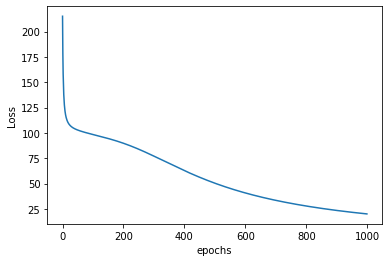

In [9]:
# training loss
plt.figure
plt.plot(np.arange(epochs),loss)
plt.xlabel('epochs')
plt.ylabel('Loss')

In [10]:
# test

N_test = np.shape(x_test)[0]

# compute network predictions for all test samples

y_pred = np.zeros(N_test)
for i in range(N_test):
    dummy0, dummy1, dummy3,y_pred[i] = forward(x_test[i,:],W1,b1,W2,b2)

# make binary decision
    
labels_pred = np.zeros(N_test)
labels_pred[y_pred > .5] = 1

# classification accuracy

print(np.sum(labels_pred == y_test.T)/N_test)

1.0


# Visualization of the Nonlinear Decision Boundaries of the Trained Model

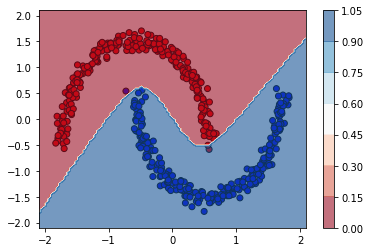

In [11]:
grid_size = 100

x = np.linspace(-2.1,2.1,grid_size)
y = np.linspace(-2.1,2.1,grid_size)

def plot_decision_boundary(x,y,X,labels):
    
    # define grid of points
    
    [xx,yy] = np.meshgrid(x,y)
    Z = np.zeros(grid_size*grid_size)
    
    # compute binary predictions for all the points of the grid
    
    for i in range(np.shape(Z)[0]):
        dummy0, dummy1, dummy3,Z[i] = forward(np.c_[xx.ravel(), yy.ravel()][i],W1,b1,W2,b2)
    
    Z[Z>0.5] = 1
    Z[Z<=0.5] = 0
    
    Z = Z.reshape(grid_size,grid_size)
    
    # scatterplot of the data and contour lines of the decision function
    
    plt.scatter(X[:,0],X[:,1], c = labels,cmap=cm_bright,edgecolors='k')
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha = 0.6)
    
# use the function to show all the info
    
plot_decision_boundary(x,y,X,Y[:,0])
plt.colorbar()

# Regression problem 

Text(0.5, 0, 'f(x,y)')

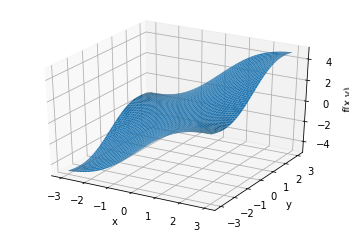

In [12]:
from mpl_toolkits.mplot3d import Axes3D

def f(x,y): 
#     return np.sin(y) + np.sin(2*x) 
     return 0.1* (10*x+5*y+ np.sin(y) *x**2 + np.sin(x)* y**2 )

step = 0.01
x = np.arange(-3,3,step)
y = np.arange(-3,3,step)

[X,Y] = np.meshgrid(x,y)

Z = f(X,Y)
# Z = StandardScaler().fit_transform(Z) #zero mean and unit variance

fig = plt.figure(1)
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y,Z)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')

Text(0.5, 0, 'f(x,y)')

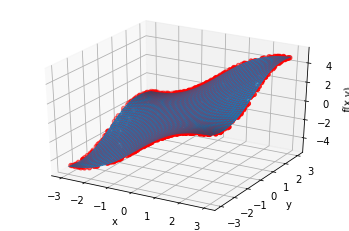

In [13]:
# sample a certain number of points from this function to form the training set

nb_samples = 3000
# nb_samples = 10000

x = np.random.uniform(-3,3,nb_samples)
y = np.random.uniform(-3,3,nb_samples)

xy = np.stack((x,y),1)

xy = StandardScaler().fit_transform(xy) #zero mean and unit variance


z = f(x,y)
# z = StandardScaler().fit_transform(z.reshape(-1,1)) #zero mean and unit variance

fig = plt.figure(1)
ax = fig.gca(projection='3d')
ax.scatter3D(x,y,z,c ='r')
ax.plot_surface(X,Y,Z)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')



In [14]:
def forward_reg(x,W1,b1,W2,b2):
    z1 = np.dot(W1,x) + b1
    a1 = sigmoid_vectorized(z1)
    z2 = np.dot(W2,a1) + b2
    return(z1,a1,z2)

def backward_reg(W1,b1,W2,b2,y,ds,z1,a1,z2,x):
    dz2 = ds*(z2-y)
    dw2 = dz2 * a1
    db2 = dz2
    da1 = np.dot(dz2,W2)
    dz1 = da1*(a1*(1-a1))
    dw1 = np.zeros((nb_neurons_hidden_layer,input_size))
    for i in range(nb_neurons_hidden_layer):
        dw1[i,:] = dz1[i]*x
    db1 = dz1
    return dw2,db2,dw1,db1

def network_training_reg(X,Y,lr,epochs,ds):
    
    # random initialization of the parameters

    W1 = np.random.randn(nb_neurons_hidden_layer,input_size)
    b1 = np.random.randn(nb_neurons_hidden_layer)

    W2 = np.random.randn(output_size,nb_neurons_hidden_layer)
    b2 = np.random.randn(output_size)

    loss = np.zeros(epochs) # total loss function value
    
    # loop over epochs
    
    for k in range(epochs):
    
        # initialize gradients and loss
    
        N = np.shape(X)[0]
        loss_ = 0
        dw2 =  np.ones((output_size,nb_neurons_hidden_layer))
        db2 =  np.ones(output_size)
        dw1 =  np.ones((nb_neurons_hidden_layer,input_size))
        db1 =  np.ones(nb_neurons_hidden_layer)

        # inner loop over all samples
        
        for i in range(N):
            
            # compute the output of the model for the current input
            
            z1_curr,a1_curr,z2_curr = forward_reg(X[i,:],W1,b1,W2,b2)
            
            # compute the loss function value
            
            loss_curr = (z2_curr-Y[i])**2
            
            # add the current loss to the total loss
            
            loss_ = loss_ + loss_curr
            
            # compute the gradients
            
            dw2_curr,db2_curr,dw1_curr,db1_curr = \
                backward_reg(W1,b1,W2,b2,Y[i],ds,z1_curr,a1_curr,z2_curr,X[i,:])
            
            # add the current gradient values to the total gradient values
            
            dw2 = dw2 + dw2_curr
            db2 = db2 + db2_curr
            dw1 = dw1 + dw1_curr
            db1 = db1 + db1_curr
            
        # print loss every 50 epochs    
        
        loss[k] = loss_
        if np.mod(k,50) == 0: 
            print(loss_)
       
    
        # perform gradient descent with the same step size for all parameters

        W2 = W2 - lr*dw2
        b2 = b2 - lr*db2
        W1 = W1 - lr*dw1
        b1 = b1 - lr*db1
        
    return(W2,b2,W1,b1,loss)

In [19]:
lr = 0.2*10**(-3)
epochs = 2000

nb_neurons_hidden_layer = 15

ds = 1
W2,b2,W1,b1,loss = network_training_reg(xy, z, lr, epochs,ds) 

[36754.90887081]
[291.14398188]
[232.30149283]
[195.52636152]
[164.34508103]
[138.73868507]
[120.13517912]
[107.63409134]
[99.19031162]
[93.1528446]
[88.54696055]
[84.85722946]
[81.81098138]
[79.25238105]
[77.08143404]
[75.22676212]
[73.63364948]
[72.25848688]
[71.06583059]
[70.02657939]
[69.11669473]
[68.31623464]
[67.60859784]
[66.97992167]
[66.41859756]
[65.91487869]
[65.46056062]
[65.04872016]
[64.67350134]
[64.3299392]
[64.01381451]
[63.72153371]
[63.45002932]
[63.1966774]
[62.95922882]
[62.73575203]
[62.52458527]
[62.32429665]
[62.13365064]
[61.95157995]


Text(0, 0.5, 'Loss')

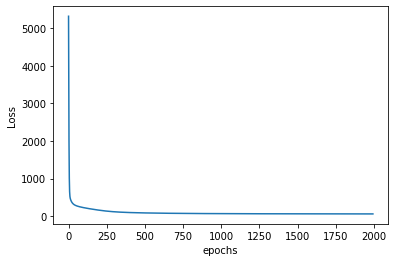

In [20]:
# training loss
plt.figure()
plt.plot(np.arange(epochs-6),loss[6:])
plt.xlabel('epochs')
plt.ylabel('Loss')


Text(0.5, 0, 'f(x,y)')

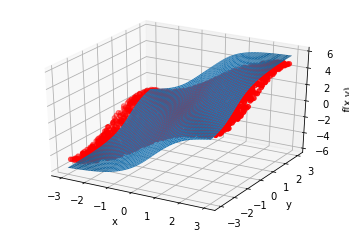

In [23]:
# %matplotlib notebook
# %matplotlib inline

step = 0.01
x_grid = np.arange(-3,3,step)
y_grid = np.arange(-3,3,step)

[X,Y] = np.meshgrid(x_grid,y_grid)

Z_net = np.zeros(np.shape(Z))

for i in range(np.shape(X)[0]):
    for j in range(np.shape(Y)[0]):
        dummy0, dummy1 ,Z_net[j,i] = forward_reg(np.stack((X[0,i],Y[j,0]),0),W1,b1,W2,b2)


fig = plt.figure(1)
ax = fig.gca(projection='3d')
ax.scatter3D(x,y,z,c ='r')
ax.plot_surface(X,Y,Z_net);

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')